In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mesa import Model, Agent
from mesa.time import RandomActivationByType, BaseScheduler
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import networkx as nx


In [13]:

class Market(Model):
    """Model class for the Market model. """

    def __init__(self, F=50, H=300, firms_production=1200

                 ):
        """Initialization of the CRAB model.

        Args:
            F                  : Number of  firm agents
            H                   : Number of household agents
        """
        # Number of agents for initialization
        self.init_n_firms = F
        self.init_n_hh = H
        self.current_id = 0
        self.graphs = []

        # Set up the  order
        self.schedule = BaseScheduler(self)

        # create households
        for j in range(self.init_n_hh):

            income =  np.random.uniform(1, 10)
            a = Household(self, income)
            self.schedule.add(a)

        # Create firms
        for i in range(self.init_n_firms):

            quality = np.random.uniform(0, 1)
            price = 1
            a = Firm(self, quality, price, production=firms_production)
            self.schedule.add(a)

        # Datacollector
        self.datacollector = DataCollector(


            agent_reporters={"Type": lambda a: type(a).__name__,
                             "Quality": lambda a: a.quality if type(a) is Firm else None,
                             "Revenue": lambda a: a.revenue if type(a) is Firm else None,
                             "Quantity_sold": lambda a: a.quantity_sold if type(a) is Firm else None,
                             "Price": lambda a: a.price if type(a) is Firm else None,
                            "Initial_budget": lambda a: a.initial_budget if type(a) is Household else None,
                             "budget": lambda a: a.budget if type(a) is Household else None
                             }
        )



    def step(self):
        """
        Run one step of the model.
        """
        # create a list with firms object
        self.available_firms = [
            agent for agent in self.schedule.agents if type(agent) is Firm]
        # create a networkx graph where the nodes are the firms and households

        self.G = nx.Graph()
        self.G.add_nodes_from(self.schedule.agents)
        




        self.datacollector.collect(self)
        self.schedule.step()
        # store the graph in a list
        self.graphs.append(self.G.copy())
        
        # plot the graph
       # nx.draw(self.G, with_labels=True)
    """
    Firms agent

    Parameters
    ----------

    """
class Firm(Agent): 

    def __init__(self, model, quality, price, production=10):
        super().__init__(model.next_id(), model)

        # Compur().__init__(model.next_id(), model)
        self.quality = quality
        self.price = price
        self.production = production
        self.initial_production = production
        self.revenue = 0
        self.price_change = 0.01
        self.quantity_sold = 0

    def step(self):
       # print('I am ', self.unique_id, type(self) )
        # compute the revenue
        self.revenue = self.price * (self.initial_production - self.production)
        # increase the price if  the production is 0.3 of the initial production
        if self.production < 0.3 * self.initial_production:
            self.price = self.price * (1 + self.price_change)

        # decrease the price if the production is 0.3 of the initial production
        elif self.production > 0.7 * self.initial_production:
            self.price = max(0.1, self.price * (1 - self.price_change))

        self.quantity_sold = (self.initial_production - self.production)
        self.production = self.initial_production


class Household(Agent):
    """
    Household  agent

    Parameters
    ----------

    """

    def __init__(self, model, budget):

        super().__init__(model.next_id(), model)

        self.budget = budget
        self.initial_budget = budget

    def step(self):
       # print('I am ', self.unique_id, type(self))

        self.budget = self.initial_budget
   
        while self.budget > 0:

            #if len(self.model.available_firms) > 0:
                # print( " I am after thelen(self.model.available_firms))
            quality = 0
            buyer = None
            for firm in self.model.available_firms:
                if (firm.quality > quality) and (firm.price <= self.budget):
                    buyer = firm
                    quality = firm.quality

            #print(buyer)
            if buyer !=  None:
                buyer.production -= 1 
                self.budget -= buyer.price
                # if add an edge between the buyer and the seller to the graph if there is no edge
                if not self.model.G.has_edge(self, buyer):
                    self.model.G.add_edge(self, buyer)
                    self.model.G[self][buyer]['weight'] = 0
                   
                # increase the link weight by the price
                self.model.G[self][buyer]['weight'] += buyer.price
            
         
                #print(buyer.production)
                #

                if buyer.production <= 0:
                    self.model.available_firms.remove(buyer)
               # print(buyer.production)
            else:
                break
        
                    
                '''
                if buyer.production > self.budget/buyer.price:
                    self.quantity = self.budget/buyer.price
                else:
                    self.quantity = buyer.production
                # print(self.quantity)
                # update the budget
                self.budget = self.budget - self.quantity*buyer.price
                # update the production
                buyer.production = buyer.production - self.quantity
                #print( ' My budget is ', self.budget)
                # if the production is 0, the firm is removed from the list of available firms
                '''
    
             

        # select a


In [14]:
model = Market(5,25, 120)
steps = 1000
for i in range(steps):
    #print('step', i)
    model.step()
    

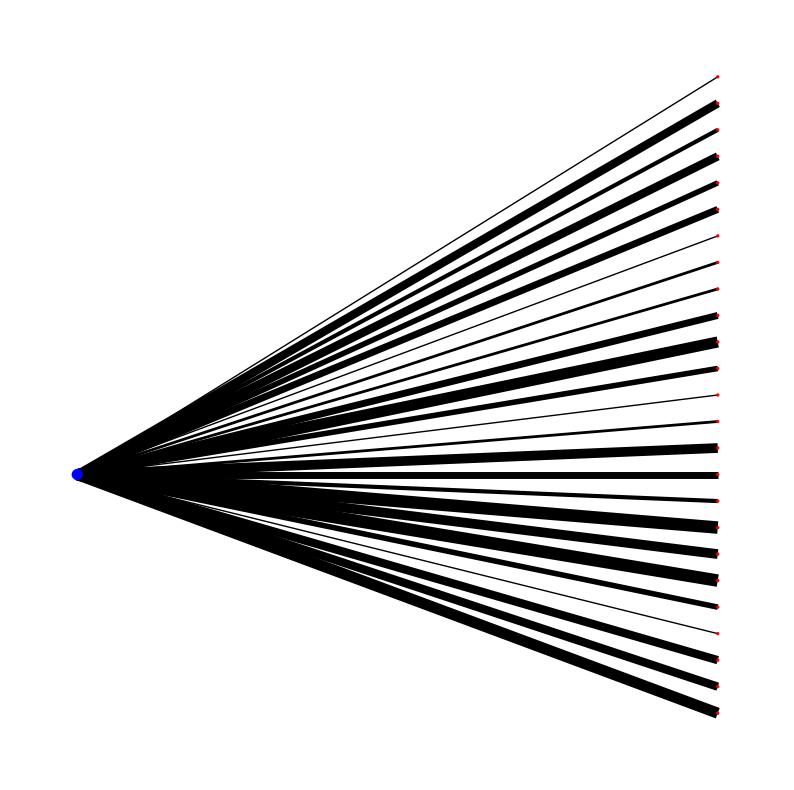

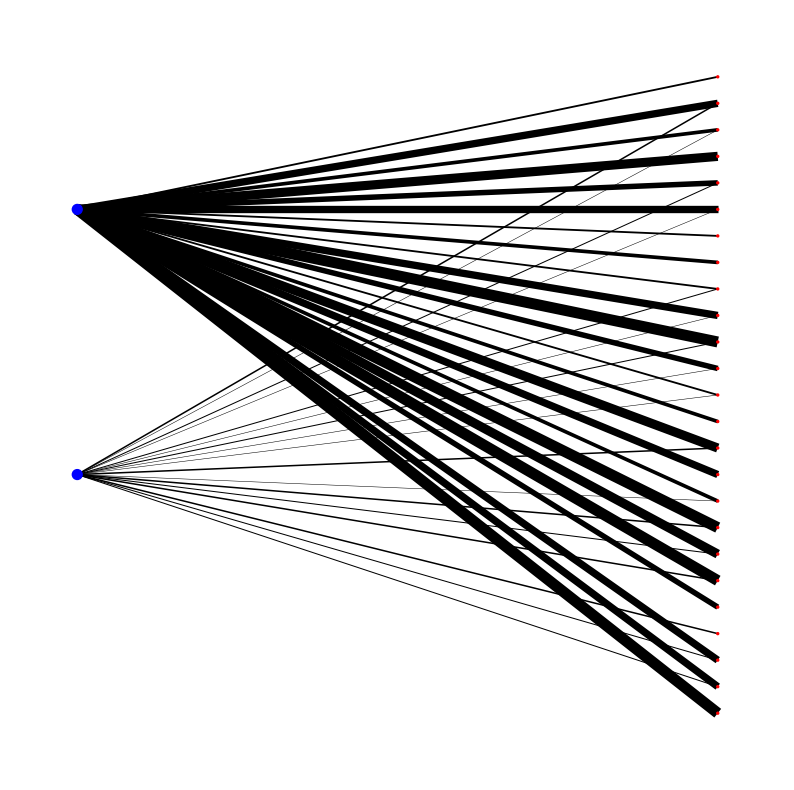

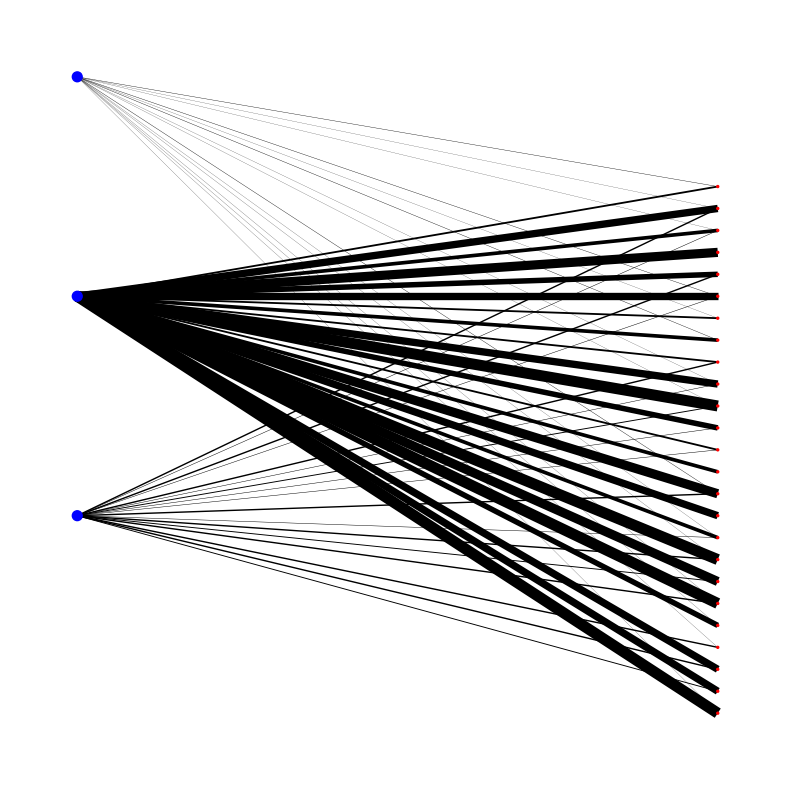

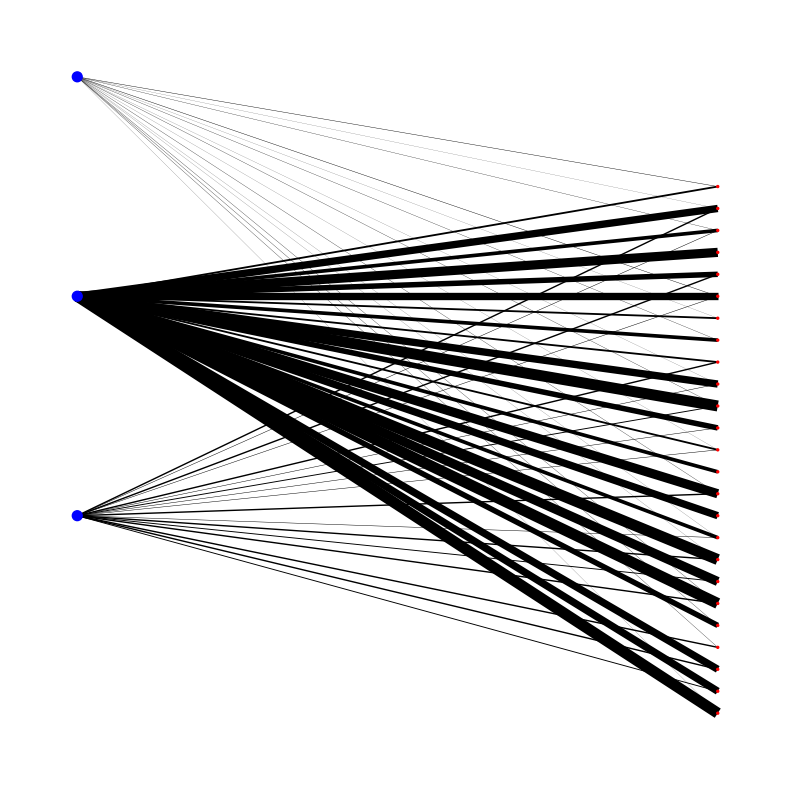

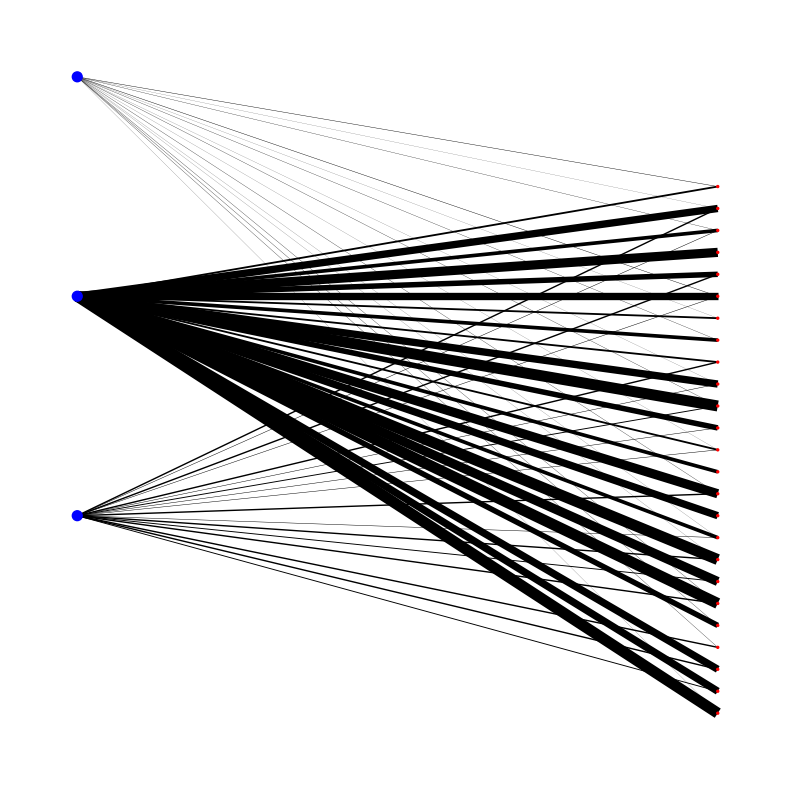

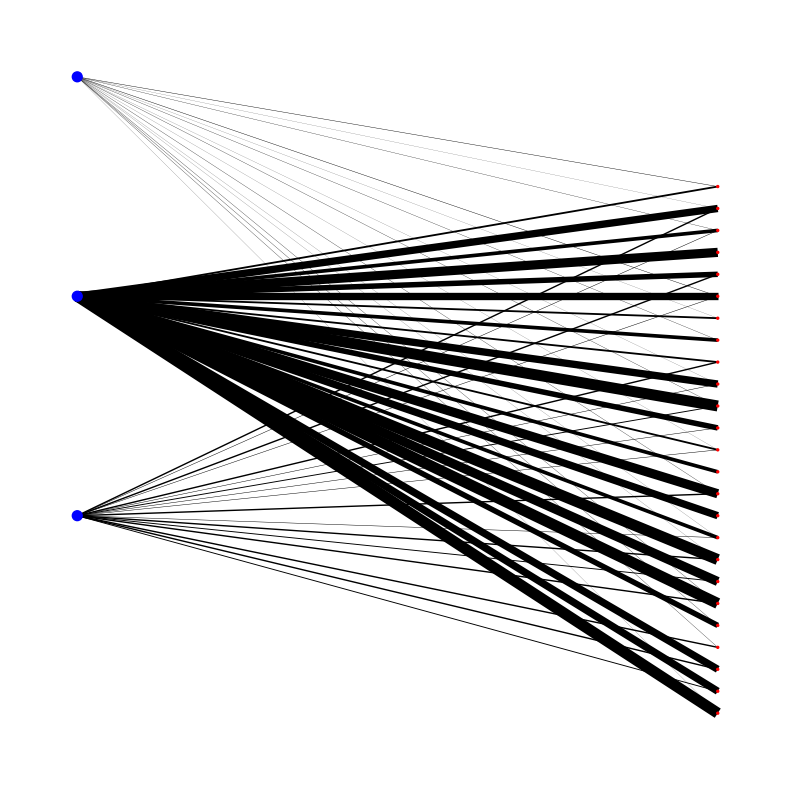

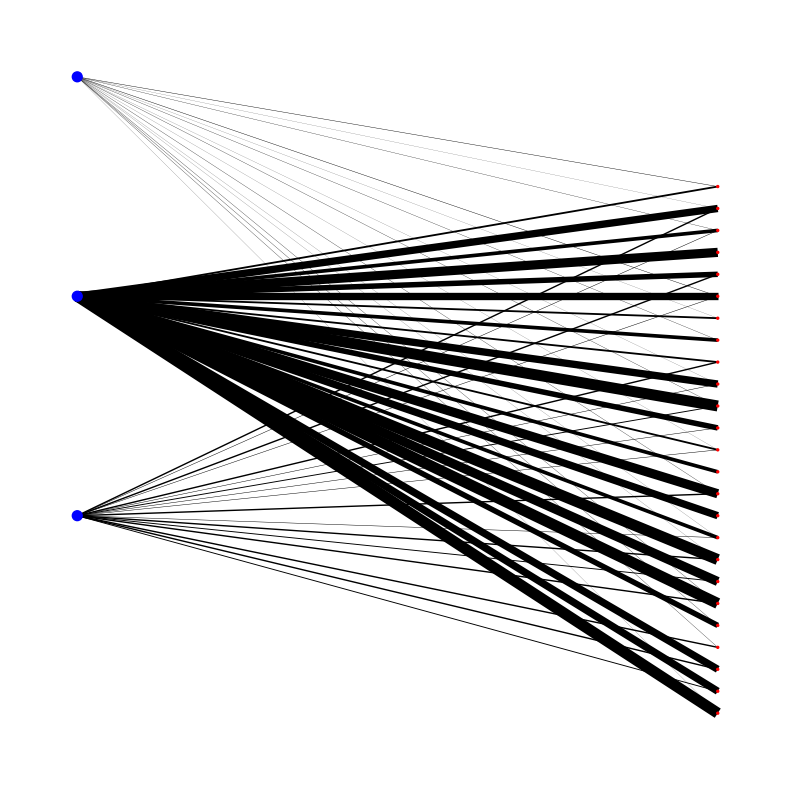

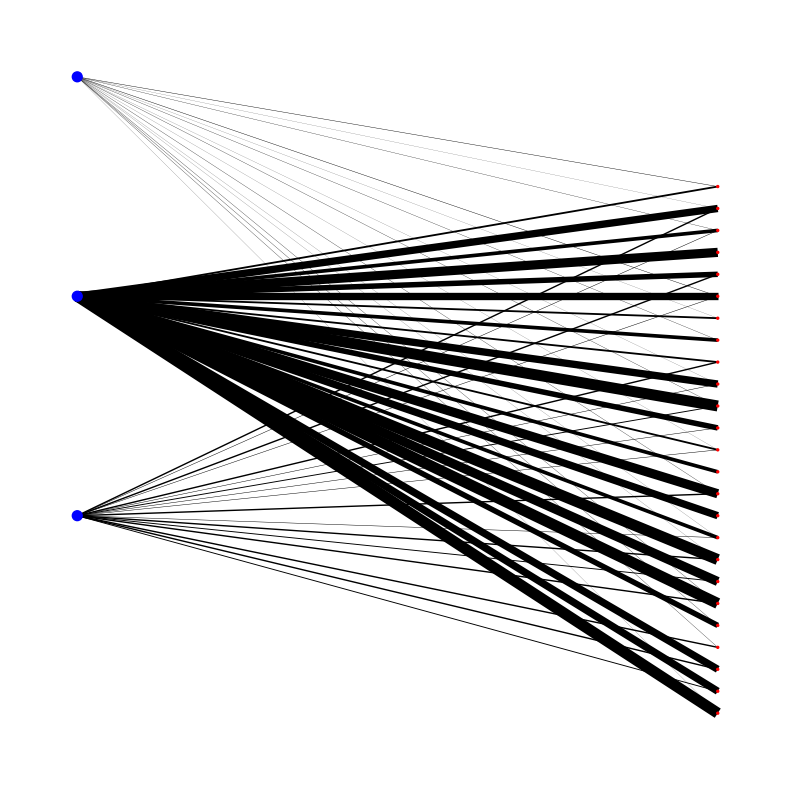

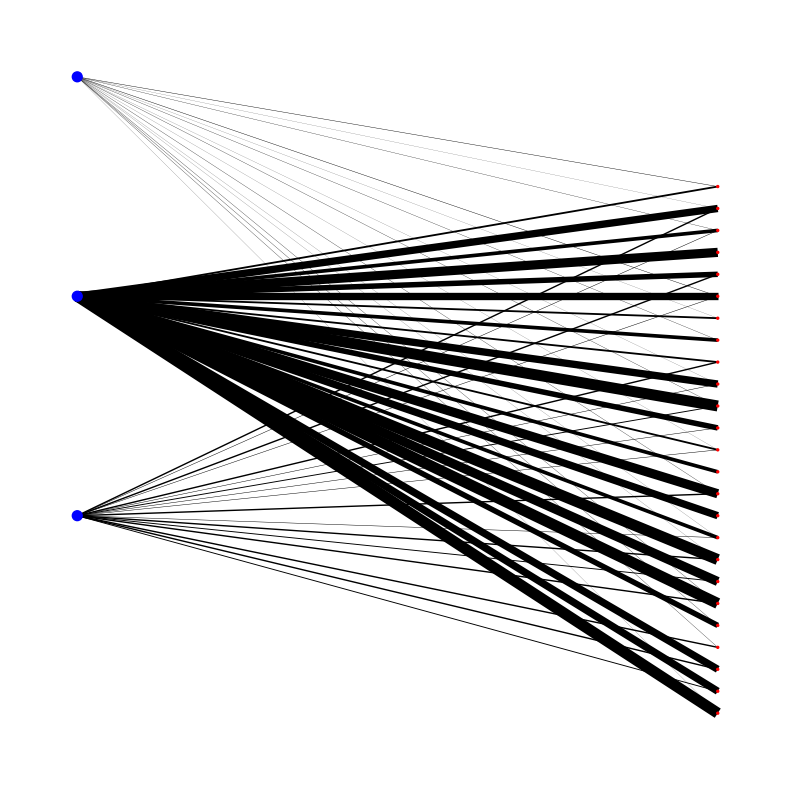

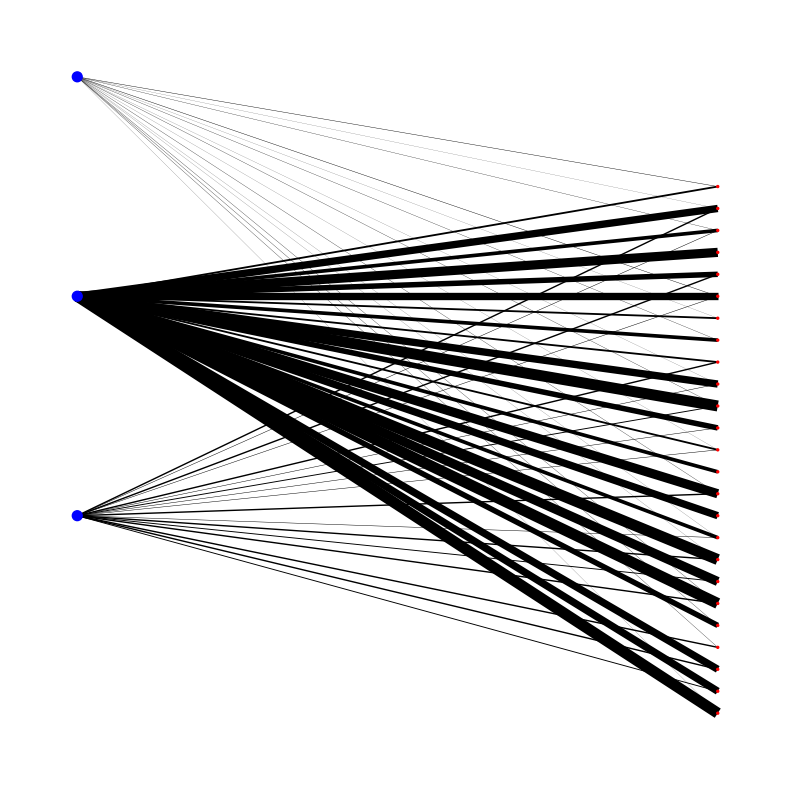

In [15]:
# draw the graph of the last step with  Weight
# remove the nodes with no edges
for i in range(len(model.graphs)):
    if i % 100 == 0:
        model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))
        # color the nodes by type
        color_map = []
        node_map = []
        pos = {}
        f = 1
        h = 1
        for node in model.graphs[i]:
            if type(node) is Firm:
                color_map.append('blue')
                node_map.append(50)
                pos[node] = (1, f * 10)
                f += 1
            else:
                color_map.append('red')
                node_map.append(2)
                pos[node] = (2, h)
                h += 1
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # draw the bipartite graph using the node color map

        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)
        plt.show()



In [16]:
import seaborn as sns



In [4]:
nx = model.datacollector.get_model_vars_dataframe().reset_index()


In [17]:
df = model.datacollector.get_agent_vars_dataframe().reset_index()

In [18]:
# for each Step, computes the HHI for each Firm
df_firm = df.loc[df['Type'] == 'Firm']
# normalize df_firm['Revenue'] in each Step
df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
# square the Market_share
df_firm['R'] = df_firm['Market_share']**2
# compute the HHI
HHI = df_firm.groupby(['Step'])['R'].sum()

#df_firm['HHI'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x**2).groupby(['Step', 'Type']).transform('sum')



/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_6900/3487603048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_6900/3487603048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['R'] = df_firm['Market_share']**2


<AxesSubplot:xlabel='Step'>

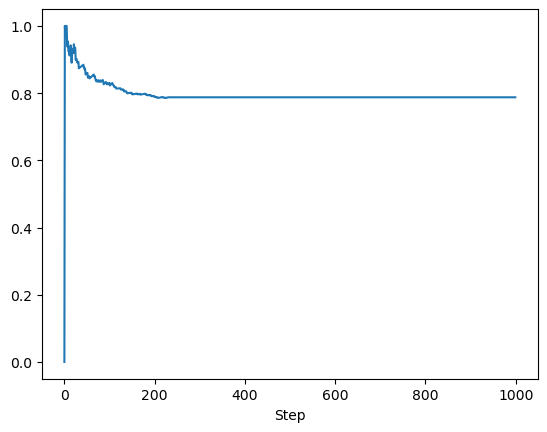

In [19]:
HHI.plot()

KeyboardInterrupt: 

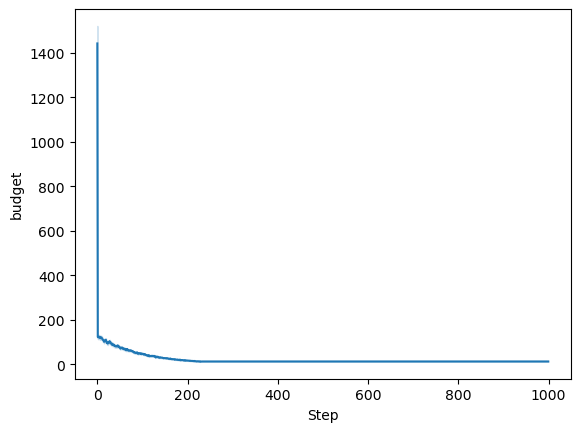

In [12]:
#sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')
sns.lineplot(data=df, y='budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Initial_budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Price'>

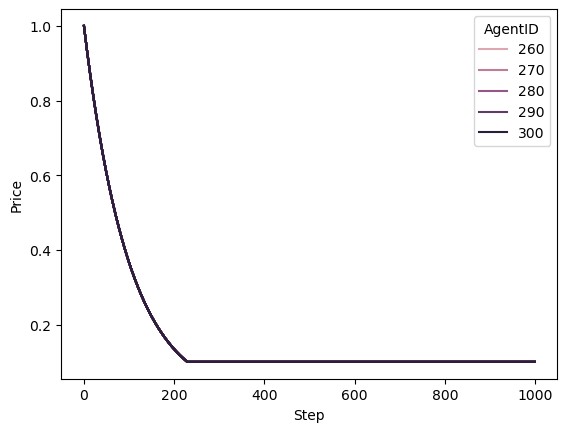

In [14]:
sns.lineplot(data=df_firm, y='Price', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Quantity_sold'>

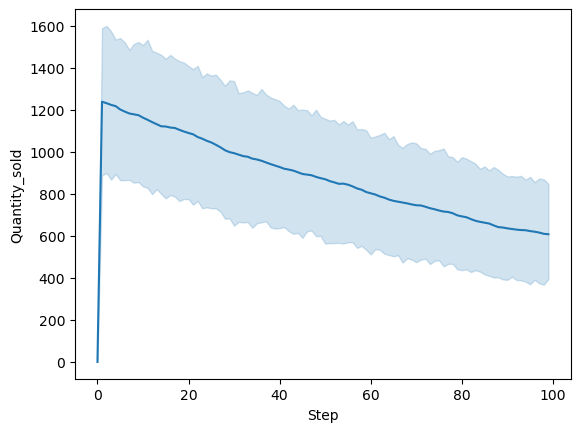

In [67]:
sns.lineplot(data=df, y='Quantity_sold', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Revenue'>

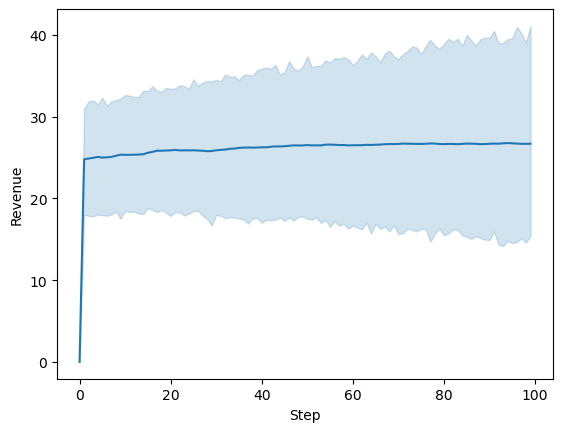

In [68]:
sns.lineplot(data=df, y='Revenue', x='Step')


<AxesSubplot:>

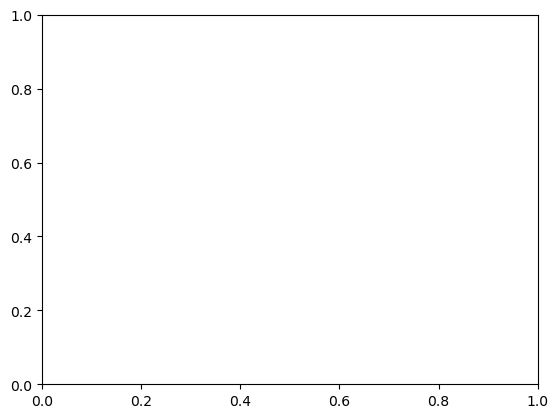

In [69]:
sns.lineplot(data=df.loc[df['AgentID'] == 1020],
             y='Revenue', x='Step', hue='AgentID')


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Household')].sort_values('budget')


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Firm')].sort_values('Quality')


In [ ]:
sns.barplot(data=df.loc[(df['Step'] == 0) & (
    df['Type'] == 'Firm')], y='Quality', x='AgentID')


In [ ]:
df.loc[df['AgentID'] == 1009]


In [ ]:

# for each step plot use seaborn to do a 1x2 plot with the distribution of the "Price" and "Revenue" of the firms
for i in range(steps):
    if i % 10 == 0:
        df1 = df[df["Step"] == i]
        df1 = df1[df1["Type"] == "Firm"]
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(df1["Price"], ax=ax[0])
        sns.histplot(df1["Revenue"], ax=ax[1])
        # set the title of the plot to the step
        fig.suptitle("Step " + str(i))
        plt.show()


In [54]:
firms = df.loc[df['Type'] == "Firm"]
df.loc[(df['Type'] == "Firm") & (df['Step'] == 99)]['Revenue'].sum()
hhi = pd.DataFrame(data={'step': range(0,100)})
hhi = hhi.assign(volume=lambda x: df.loc[(df['Type'] == "Firm") & (df['Step'] == x.step)]['Revenue'].sum())
hhi 

ValueError: Can only compare identically-labeled Series objects